# Statistics

Statistics of the PDNS-Net graph

In [1]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import src.temporal_loader as tl

In [2]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    mpl.rc("font", size=10)
    mpl.rc("figure", dpi=300)
    
set_style()

In [3]:
cuda_device = 7

if torch.cuda.is_available():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.cuda.set_device(cuda_device)
    
torch.manual_seed(42)

## Load Graph

In [4]:
kg_path = lambda graph_name: f'./data/{graph_name}'
dataset = tl.DNS(root=kg_path('DNS_2m'))
data = dataset[0]

##  Resolutions

In [5]:
def get_edges(source):
    edges = source[('domain_node', 'resolves', 'ip_node')].edge_index.t().cpu().numpy()
    edges = pd.DataFrame(edges, columns=['src', 'tgt'])
    return edges

In [6]:
first_seen_exp = [get_edges(data[0])]

all_resolutions = first_seen_exp[0]
for i, resolutions in enumerate(data[1:]):
    resolutions = get_edges(resolutions)
    all_resolutions = pd.concat([all_resolutions, resolutions])
    
    duplicates = all_resolutions[all_resolutions.duplicated()]
    unique_expansion = pd.concat([resolutions, duplicates]).drop_duplicates(keep=False)
    
    first_seen_exp.append(unique_expansion)
    all_resolutions = all_resolutions.drop_duplicates()

/tmp/ipykernel_43498/3506480670.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in g.get_yticks()/1000])


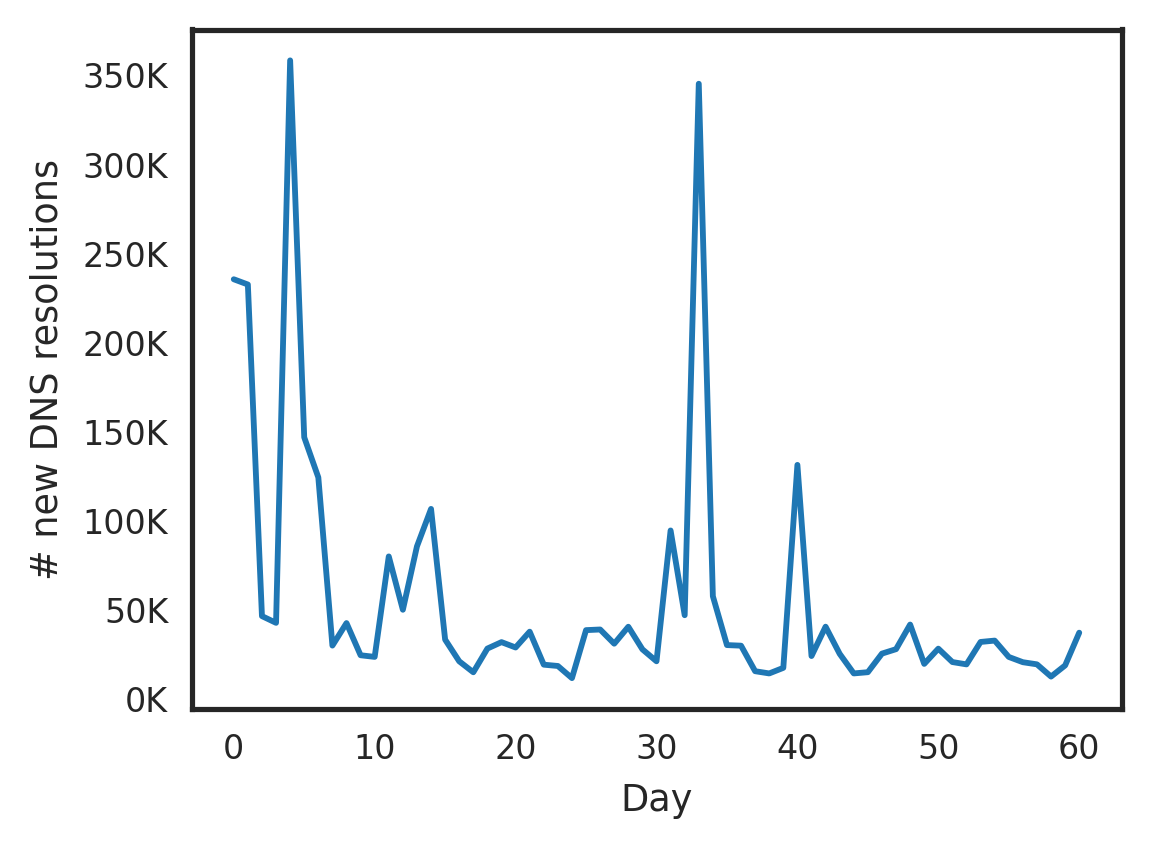

In [7]:
first_seen_stats = pd.DataFrame([{'Day':i, '# new DNS resolutions':len(e)} for i, e in enumerate(first_seen_exp)])

plt.figure(figsize=(4, 3))
g = sns.lineplot(x='Day', y='# new DNS resolutions', data=first_seen_stats)
g.set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in g.get_yticks()/1000])
plt.show()

## Nodes

### Domains

In [8]:
domains, ips = dataset.fetch_node_info()

/tmp/ipykernel_43498/3187741035.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in g.get_yticks()/1000])


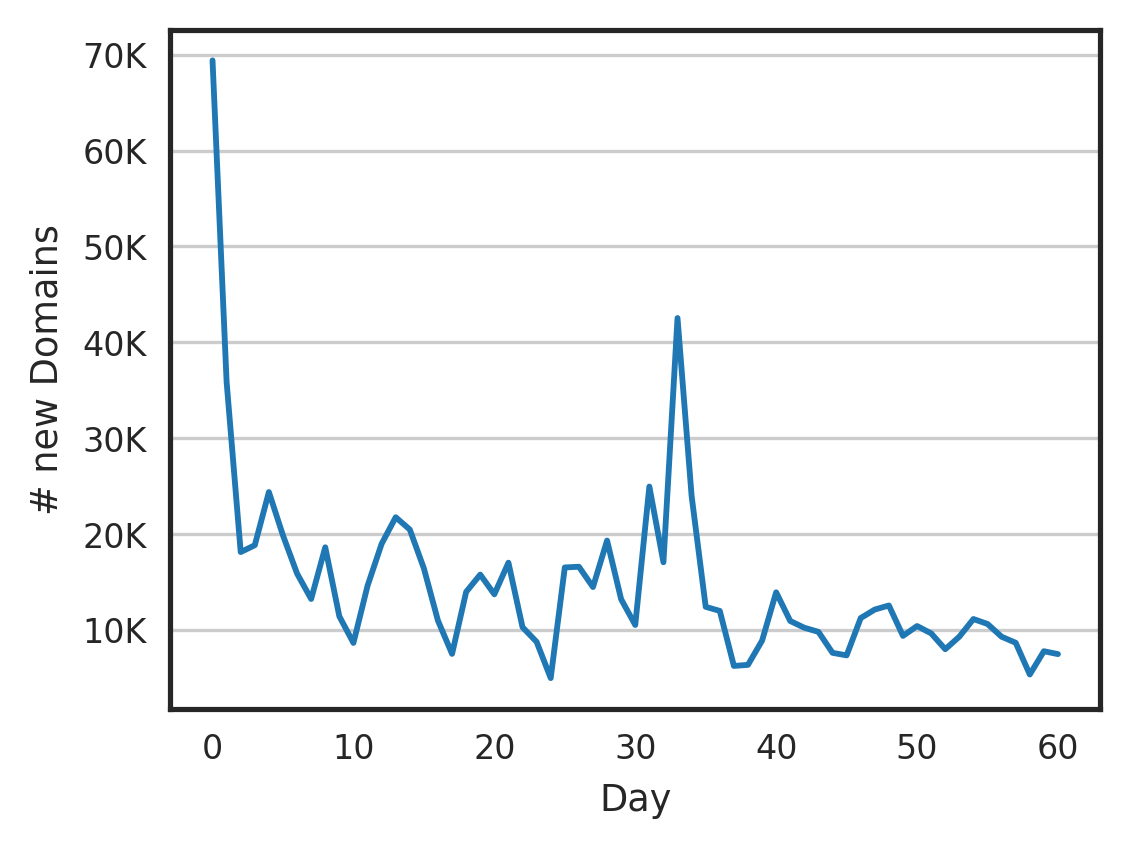

In [9]:
domain_stats = domains.value_counts('timestamp').reset_index().rename(columns={0: '# new Domains', 'timestamp': 'Day'})

plt.figure(figsize=(4, 3))
g = sns.lineplot(x='Day', y='# new Domains', data=domain_stats)
g.set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in g.get_yticks()/1000])
plt.grid(axis='y')
plt.show()

### IPs

/tmp/ipykernel_43498/2972680653.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in g.get_yticks()/1000])


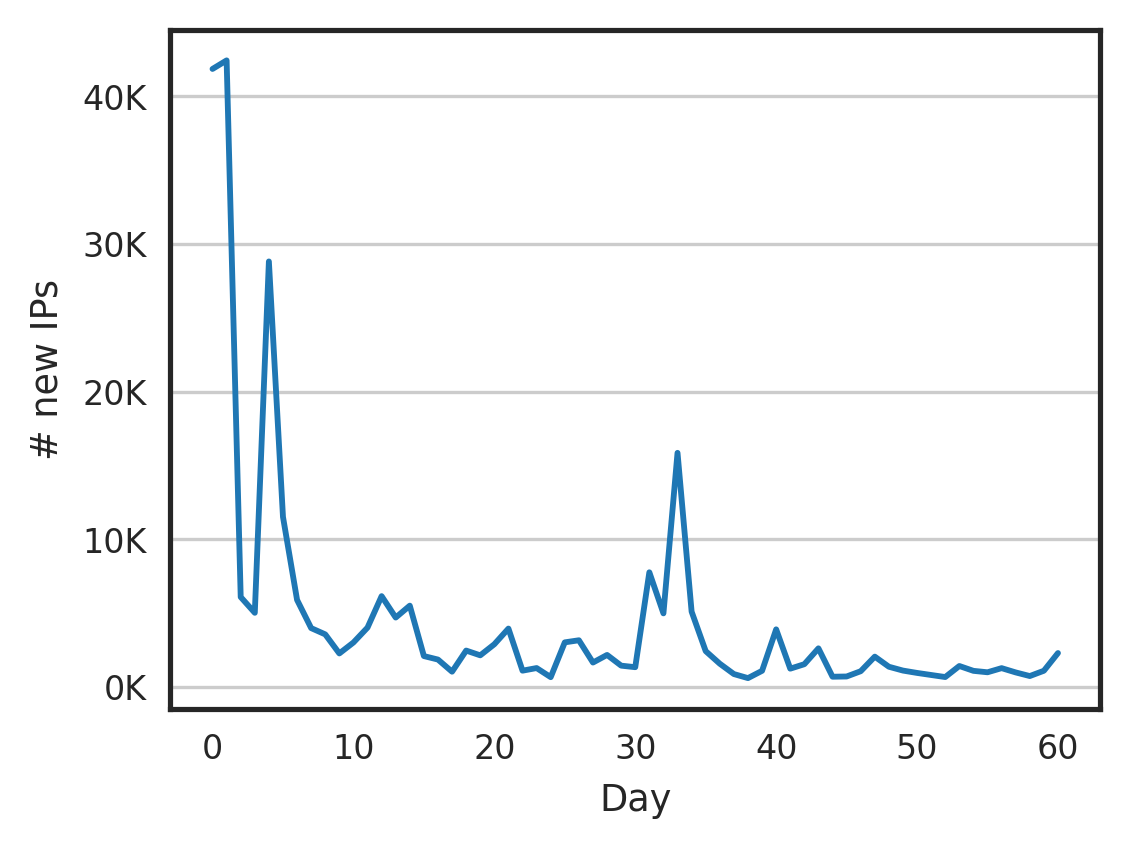

In [10]:
ip_stats = ips.value_counts('timestamp').reset_index().rename(columns={0: '# new IPs', 'timestamp': 'Day'})

plt.figure(figsize=(4, 3))
g = sns.lineplot(x='Day', y='# new IPs', data=ip_stats)
g.set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in g.get_yticks()/1000])
plt.grid(axis='y')
plt.show()